# Electron Cooling

In [1]:
%load_ext autoreload

## Notebook Initialization

In [2]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
import pickle
import copy

np.set_printoptions(threshold=np.nan)


import darkhistory.physics as phys
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.transferfunction as tf
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec

## Import ICS Tables

In [3]:
raw_nonrel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_nonrel.raw","rb"))
raw_rel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_rel.raw","rb"))
raw_engloss_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_englossspec.raw","rb"))

Prepare the ICS transfer functions from these files.

In [4]:
eleceng = 10**np.arange(0, 12, 0.024)
photeng = 10**np.arange(-2, 12, 0.028)
T = phys.TCMB(1000)

ICS_tf = ics_spec(eleceng, photeng, T, 
                  nonrel_tf = raw_nonrel_ICS_tf, rel_tf = raw_rel_ICS_tf
                 )

engloss_tf = engloss_spec(eleceng, photeng, T, 
                          nonrel_tf = raw_engloss_tf, 
                          rel_tf = raw_rel_ICS_tf
                         )

print(eleceng.size, photeng.size)

500 500


Check that everything is working as expected...

[0.0001, 10000000000000.0, 1e-16, 1000.0]

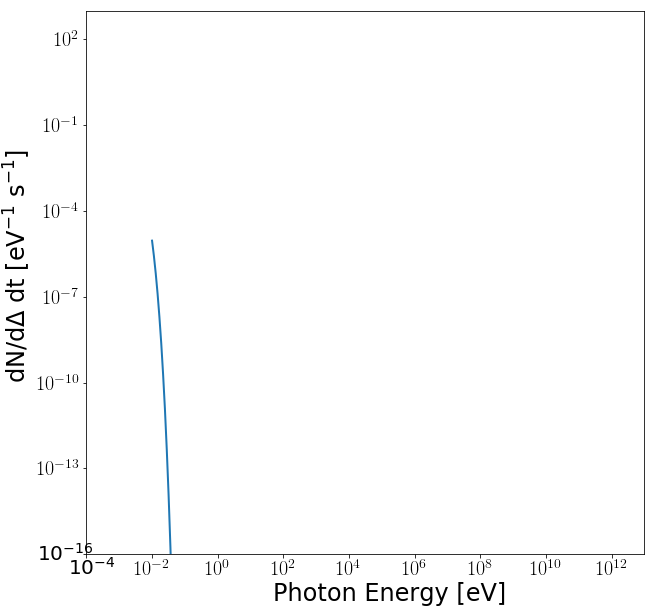

In [5]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
# comp_elec_kineng = np.array([1,1e4, 1e7, 1e8, 1e10, 1e11])

# engloss_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)
engloss_tf.plot(ax, ind=3, indtype='ind', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/d$\Delta$ dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e13, 1e-16, 1e3])

In [6]:
engloss_tf[3].totN('bin')

array([  5.88332688e-09,   3.49846357e-09,   1.97276727e-09,
         1.06456278e-09,   5.48512460e-10,   2.69226060e-10,
         1.23464012e-10,   5.31929210e-11,   2.15794800e-11,
         8.21821397e-12,   2.90769021e-12,   9.36039348e-13,
         2.78637872e-13,   7.63907027e-14,   1.92088087e-14,
         4.27965917e-15,   8.53143727e-16,   1.52785539e-16,
         2.44467784e-17,   3.43070772e-18,   4.06821537e-19,
         4.19560495e-20,   3.73624000e-21,   2.85177977e-22,
         1.75408024e-23,   8.84734277e-25,   3.68559141e-26,
         1.25574234e-27,   3.38537500e-29,   6.75713550e-31,
         1.05121532e-32,   1.25839485e-34,   1.14394468e-36,
         7.07328123e-39,   3.06890769e-41,   9.46291265e-44,
         2.03790166e-46,   2.88912266e-49,   2.39455811e-52,
         1.27180159e-55,   4.23044188e-59,   8.60762076e-63,
         8.80000519e-67,   4.77885674e-71,   1.41020378e-75,
         2.19205890e-80,   1.61490919e-85,   4.56148385e-91,
         0.00000000e+00,

In [7]:
sec_elec_tf = copy.deepcopy(engloss_tf)

for in_eng, spec in zip(sec_elec_tf.get_in_eng(), sec_elec_tf):
    spec.engloss_rebin(in_eng, sec_elec_tf.get_in_eng())

[0.0001, 1000000000000.0, 1e-16, 1000.0]

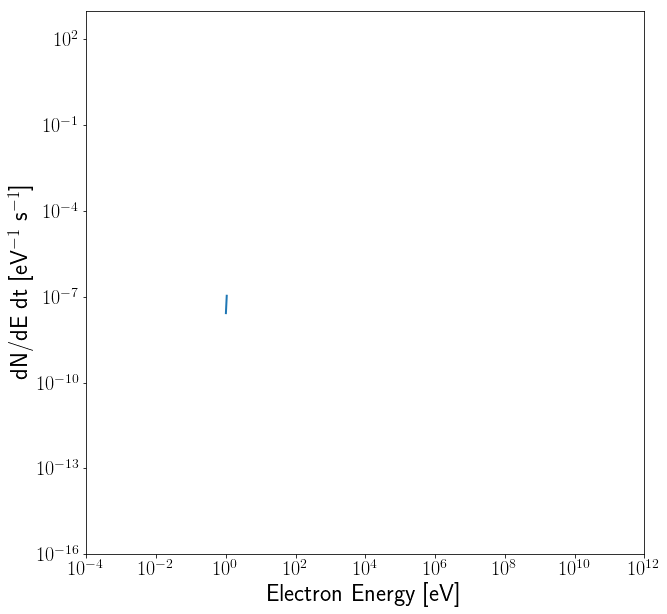

In [8]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
# comp_elec_kineng = np.array([1,1e4, 1e7, 1e8, 1e10, 1e11])

# sec_elec_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)
sec_elec_tf.plot(ax, ind=1, indtype='ind', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Electron Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e12, 1e-16, 1e3])

In [9]:
print(sec_elec_tf.get_eng())
sec_elec_tf[30].totN('bin')

[  1.00000000e+00   1.05681751e+00   1.11686325e+00   1.18032064e+00
   1.24738351e+00   1.31825674e+00   1.39315680e+00   1.47231250e+00
   1.55596563e+00   1.64437172e+00   1.73780083e+00   1.83653834e+00
   1.94088588e+00   2.05116218e+00   2.16770410e+00   2.29086765e+00
   2.42102905e+00   2.55858589e+00   2.70395836e+00   2.85759054e+00
   3.01995172e+00   3.19153786e+00   3.37287309e+00   3.56451133e+00
   3.76703799e+00   3.98107171e+00   4.20726628e+00   4.44631267e+00
   4.69894109e+00   4.96592321e+00   5.24807460e+00   5.54625713e+00
   5.86138165e+00   6.19441075e+00   6.54636174e+00   6.91830971e+00
   7.31139083e+00   7.72680585e+00   8.16582371e+00   8.62978548e+00
   9.12010839e+00   9.63829024e+00   1.01859139e+01   1.07646521e+01
   1.13762729e+01   1.20226443e+01   1.27057411e+01   1.34276496e+01
   1.41905752e+01   1.49968484e+01   1.58489319e+01   1.67494288e+01
   1.77010896e+01   1.87068214e+01   1.97696964e+01   2.08929613e+01
   2.20800473e+01   2.33345806e+01

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   3.38125501e-62,   9.24266709e-08,
         2.03279856e-06,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [15]:
pri_elec = np.array([spec.totN() for spec in sec_elec_tf])
pri_elec *= sec_elec_tf.get_in_eng()
sec_elec = np.array([spec.toteng() for spec in sec_elec_tf])
sec_phot = np.array([spec.toteng() for spec in ICS_tf])
CMB_phot = phys.CMB_eng_density(T)*phys.thomson_xsec*phys.c*np.ones_like(sec_phot)

utils.compare_arr([pri_elec, sec_elec, sec_phot, CMB_phot])

# print(c - phys.CMB_eng_density(T)*phys.thomson_xsec*phys.c)
# print(a-b-c+phys.CMB_eng_density(T)*phys.thomson_xsec*phys.c)

[[ 5.8613467e-09  5.7984475e-09  0.0051860033  0.0051966997]
 [ 8.2301429e-09  8.1463373e-09  0.0051860049  0.0051966997]
 [ 1.1491038e-08  1.1379996e-08  0.0051860065  0.0051966997]
 [ 1.5872405e-08  1.5726838e-08  0.0051860082  0.0051966997]
 [ 2.1788032e-08  2.1598372e-08  0.00518601  0.0051966997]
 [ 2.9753912e-08  2.9508053e-08  0.005186012  0.0051966997]
 [ 4.0231458e-08  3.9915867e-08  0.005186014  0.0051966997]
 [ 5.4088422e-08  5.3685588e-08  0.0051860162  0.0051966997]
 [ 7.2374633e-08  7.1862801e-08  0.0051860184  0.0051966997]
 [ 9.5962022e-08  9.531757e-08  0.0051860209  0.0051966997]
 [ 1.2657178e-07  1.2576449e-07  0.0051860234  0.0051966997]
 [ 1.662248e-07  1.6521775e-07  0.0051860261  0.0051966997]
 [ 2.1646855e-07  2.1522275e-07  0.0051860289  0.0051966997]
 [ 2.8054984e-07  2.7901588e-07  0.0051860319  0.0051966997]
 [ 3.6216878e-07  3.6028715e-07  0.0051860351  0.0051966997]
 [ 4.6391371e-07  4.616233e-07  0.0051860385  0.0051966997]
 [ 5.9163906e-07  5.8886288e-07

0

In [11]:
%%prun
sec_phot_tf = tf.TransFuncAtRedshift([], dlnz=-1)
sec_phot_tf.rs = ICS_tf.rs
lowengelec_tf = tf.TransFuncAtRedshift([], dlnz=-1)
lowengelec_tf.rs = ICS_tf.rs
elec_high_eng = eleceng[eleceng > 3000]
elec_low_eng  = eleceng[eleceng <= 3000]

highengelec_ind = np.arange(eleceng.size)[eleceng > 3000]
lowengelec_ind  = np.arange(eleceng.size)[eleceng <= 3000]

ICS_tf_high_eng = tf.TransFuncAtRedshift(
    ICS_tf[highengelec_ind[0]:], dlnz=-1)

sec_elec_tf_high_eng = sec_elec_tf.at_val(
    highengelec_ind, highengelec_ind, interp_type='bin'
)

sec_elec_tf_low_eng = sec_elec_tf.at_val(
    highengelec_ind, lowengelec_ind, interp_type='bin'
)

for i,eng in zip(np.arange(elec_high_eng.size), elec_high_eng):
    delta_spec = np.zeros_like(elec_high_eng)
    delta_spec[i] = 1  
    sec_phot_spec_N = spectools.scatter(ICS_tf_high_eng, mode='N', out_mode='N',
                                      eng_arr = elec_high_eng, N_arr = delta_spec, new_eng=photeng)
    sec_elec_spec_N = spectools.scatter(sec_elec_tf_high_eng, mode='N', out_mode='N',
                                      eng_arr = elec_high_eng, N_arr = delta_spec, new_eng=elec_high_eng)
    sec_lowengelec_spec = spectools.scatter(sec_elec_tf_low_eng, mode='N', out_mode='dNdE',
                                            eng_arr = elec_high_eng, N_arr = delta_spec, new_eng=elec_low_eng)
    sec_lowengelec_spec.in_eng = eng
    if sec_phot_tf.spec_arr and i > 0:
        rescatter_spec_N = sec_elec_spec_N[0:i]
#         ICS_tf_elec_sec = tf.TransFuncAtRedshift(ICS_tf[highengelec_ind[0]:highengelec_ind[i]], dlnz = -1)
#         sec_phot_spec_N += spectools.scatter(ICS_tf_elec_sec, mode='N', out_mode='N', 
#                                           eng_arr = elec_high_eng[0:i], N_arr = rescatter_spec_N, new_eng = photeng)
        sec_phot_spec_N += spectools.scatter(sec_phot_tf, mode='N', out_mode='N', 
                                          eng_arr = elec_high_eng[0:i], N_arr = rescatter_spec_N, new_eng = photeng)
#         print(rescatter_spec_N)
#         print(sec_elec_spec_N)
    sec_phot_spec = spectools.rebin_N_arr(sec_phot_spec_N, photeng)
    sec_phot_spec.in_eng = eng
    sec_phot_spec.rs = ICS_tf.rs
    
    sec_phot_tf.append(sec_phot_spec)
    lowengelec_tf.append(sec_lowengelec_spec)
    
        
        
        
    

[0.0001, 10000000000000.0, 1e-16, 10000000000.0]

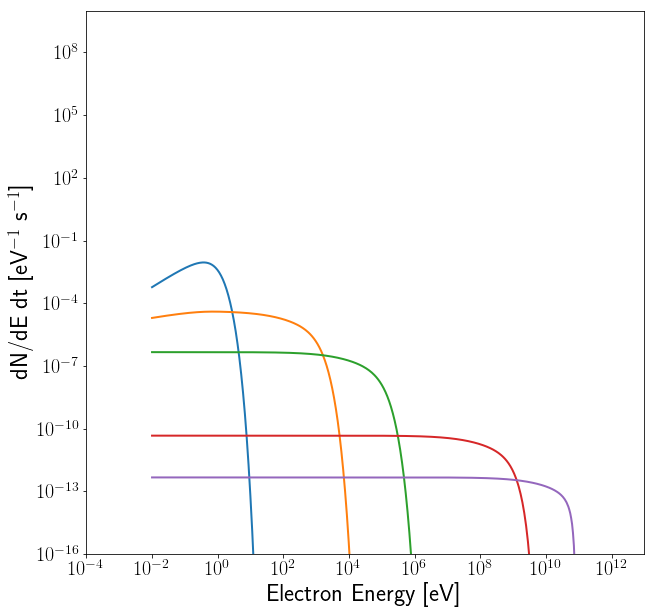

In [12]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
comp_elec_kineng = np.array([1e4, 1e7, 1e8, 1e10, 1e11])

sec_phot_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Electron Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e13, 1e-16, 1e10])

In [13]:
a = np.array([1,2,3,4.0,5])
print(a.dtype.type)
issubclass(a.dtype.type, np.integer)

<class 'numpy.float64'>


False

In [14]:
phys.nH

1.8741315532120153e-07

In [ ]:
(8/3)*np.pi*phys.